# Asynchronous One Step Deep Q-Network (DQN)

### 0.Background: introduce Asynchronous to DQN

Traditional [Deep Q-Networks (DQN)](../vanilla-dqn/dqn_lunarlander.ipynb) have been highly successful in solving reinforcement learning tasks by combining Q-learning with deep neural networks. However, they often require significant computational resources and suffer from stability issues during training. To address these challenges, **Asynchronous DQN** introduces the concept of **asynchronous multi-threading**, where multiple agents (or threads) interact with their own copies of the environment in parallel. This approach provides several benefits:

1. **Improved computational efficiency**:
   - By leveraging multiple threads, the algorithm can make better use of multi-core CPUs, enabling faster training without requiring expensive GPUs.

2. **Stabilized training**:
   - Asynchronous updates reduce the correlation between consecutive updates, which helps mitigate the instability caused by highly correlated training data in traditional DQN.

3. **Enhanced exploration**:
   - By assigning different exploration policies to each thread, Asynchronous DQN encourages diverse exploration, leading to better coverage of the state-action space.

### 1. Import the Necessary Packages

In this notebook, we will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

In [10]:
import numpy as np
import gymnasium as gym
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

# for game rendering
import time
from PIL import Image
from IPython import display

device = torch.device("cpu")
print(f"Training on: {device}")

np.set_printoptions(precision=3, linewidth=120)

Training on: cpu


### 2. Explore Environment

<div style="text-align: center;">
    <img src="./images/lunar_lander.gif" alt="Mountain Car Environment" width="50%">
</div>

#### Discreate Action Space

There are four discrete actions available:

- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

#### Continuous Observation Space

The state is an 8-dimensional vector: 

- the coordinates of the lander in `x`
- the coordinates of the lander in`y`, 
- linear velocities in `x` 
- linear velocities in `y`, 
- its angle, 
- its angular velocity, and 
- a booleans that represent whether `left` leg is in contact with the ground or not.
- a booleans that represent whether `right` leg is in contact with the ground or not.

In [2]:
env = gym.make('LunarLander-v3', render_mode="rgb_array")

In [3]:
# Explore state (observation) space
print("State space:\n Continuous", env.observation_space.shape)
print(" - low:", env.observation_space.low)
print(" - high:", env.observation_space.high)

# Explore action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("State space 10 samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

# Generate some samples from the action space
print("Action space 10 samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

State space:
 Continuous (8,)
 - low: [ -2.5    -2.5   -10.    -10.     -6.283 -10.     -0.     -0.   ]
 - high: [ 2.5    2.5   10.    10.     6.283 10.     1.     1.   ]
Action space:
 Discrete(4)
--------------------------------------------------
State space 10 samples:
[[-1.672  1.372 -2.095 -6.086 -5.166 -5.27   0.695  0.296]
 [ 1.992 -0.661 -1.177 -7.604  5.288  8.819  0.297  0.361]
 [-0.732 -1.347 -0.675 -1.23  -2.339  7.345  0.199  0.341]
 [-1.572  1.812  7.556 -4.559  1.222 -4.305  0.346  0.1  ]
 [-1.231  0.994 -0.786 -0.339  4.925 -1.335  0.225  0.487]
 [ 2.081  1.051 -2.106  7.394 -2.226 -0.101  0.853  0.106]
 [ 2.332  1.49   9.098  5.481  0.42  -2.332  0.654  0.452]
 [-2.434 -1.231 -7.237 -9.658  0.472 -1.891  0.923  0.076]
 [-0.486  0.082  9.126  4.984  4.265 -0.401  0.217  0.46 ]
 [ 1.558  0.608 -2.42   4.515 -4.672 -0.155  0.712  0.597]]
Action space 10 samples:
[0 1 3 3 2 1 0 1 3 2]


### 3. Remove Replay Buffer

#### Using Experience Replay Improve Training Stability

<div style="text-align: center;">
    <img src="./images/reply-buffer.png" alt="Mountain Car Environment" width="70%">
</div>

When an agent interacts with the environment, the sequence of experience tuples can be highly correlated, which poses a risk for naive Q-learning algorithms. These algorithms, when learning sequentially from such correlated data, may lead to unstable updates, causing action values to oscillate or diverge.

To address this, a replay buffer is introduced to store experience tuples $(S, A, R, S')$ collected during interactions with the environment. By using **experience replay**, small batches of tuples are randomly sampled from the buffer for training. This random sampling breaks harmful correlations, stabilizes learning, and allows the agent to:  
1. Reuse individual experience tuples multiple times.  
2. Recall rare events.  
3. Make better overall use of past experiences.  

Experience replay thus improves the efficiency and stability of the learning process.

<span style="color: red;">Update: </span> However, asynchronous methods eliminate the need for a replay buffer. In asynchronous one-step Q-learning and related methods, multiple agents (threads) interact with their own copies of the environment in parallel. This naturally introduces diversity into the data collected by each thread, breaking the correlation between consecutive updates. As a result:

The updates from different threads act as a form of implicit decorrelation, reducing the risk of instability.
The computational complexity of managing a replay buffer is avoided, making the algorithm simpler and more efficient.
Thus, asynchronous mechanisms provide a built-in alternative to experience replay, achieving stability and efficiency without the need for a replay buffer.



### 4. Define Q Network

#### Using Neural Networks as Approximators for Q values

<div style="text-align: center;">
    <img src="./images/model-view.png" alt="Mountain Car Environment" width="70%">
</div>

This image shows the transition from a **Traditional Q Table** to a **Parameterized Q Function** in reinforcement learning. 

The Q table (left) stores discrete Q-values $ Q(s_t, a_t) $ for each state-action pair but struggles with scalability in high-dimensional spaces. The parameterized Q function (right) replaces the table with a neural network $ Q(s_t, a_t; w) $, where $ w $ are the network's parameters.

<div style="text-align: center;">
    <img src="./images/model-arch.png" alt="Mountain Car Environment" width="70%">
</div>

- Define a neural network architecture that maps states to action values $Q(s_t, a_t; w)$.


In [4]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, hidden_size=64, seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.Q = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, state):
        """Build a network that maps state -> action values."""
        actions = self.Q(state)
        return actions


# test model
q_net = QNetwork(8, 4, 16, seed=42)
# fake input, by given batch size 4
states = torch.rand((4, 8))
# fake output size
print(q_net(states).shape)

torch.Size([4, 4])


### 5. Define Agent

##### How to Learn in DQN

<div style="text-align: center;">
    <img src="./images/dqn-gradient-descent.png" alt="Mountain Car Environment" width="70%">
</div>

This image provides a visual summary of the core theory and update mechanism of **Deep Q-Network (DQN)**, showcasing the key formula derivations from **Q-Learning** to **DQN**, as well as how neural networks are used to approximate and update Q-values.

---

**1. Core Idea Based on the Bellman Equation**
- **Bellman Equation:**
  $$
  Q^*(s_t, a_t) = R_t + \gamma \max_a Q^*(s_{t+1}, a)
  $$
  - This states that the optimal Q-value for the current state-action pair equals the immediate reward $ R_t $ plus the discounted maximum Q-value of the next state.
  - The core objective of DQN is to approximate this equation using a neural network.

**2. Derivation from Q-Learning to DQN**
- **Q-Learning Update Formula:**
  $$
  Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( R_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right)
  $$
  - **TD Target:**
    $$
    R_t + \gamma \max_a Q(s_{t+1}, a)
    $$
    This represents the target Q-value for the current state, combining the immediate reward $ R_t $ and the maximum Q-value of the next state.
  - **Current Value:**
    $$
    Q(s_t, a_t)
    $$
    This is the current estimated Q-value.
  - **TD Error:**
    $$
    \delta_t = \left( R_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right)
    $$
    This measures the difference between the target Q-value and the current Q-value.

- **Neural Network Introduction:**
  - To handle continuous state spaces, DQN replaces the traditional Q-table with a neural network $ Q(s, a; w) $, where $ w $ represents the network parameters.
  - The goal is to optimize the network so that its output $ Q(s, a; w) $ approximates the true $ Q^*(s, a) $.


**3. Loss Function and Gradient Update in DQN**
- **Loss Function:**
  $$
  L(w) = \frac{1}{2} \left[ Q(s_t, a_t; w) - Q^*(s_t, a_t) \right]^2
  $$
  - Here, $ Q^*(s_t, a_t) $ is the target Q-value (TD Target) calculated using the Bellman equation.
  - The loss function minimizes the squared error between the network's output $ Q(s_t, a_t; w) $ and the target Q-value $ Q^*(s_t, a_t) $.

- **Gradient Calculation:**
  $$
  \nabla_w L(w) = \left( Q(s_t, a_t; w) - Q^*(s_t, a_t) \right) \nabla_w Q(s_t, a_t; w)
  $$
  - The gradient consists of two parts:
    1. The error term: $ Q(s_t, a_t; w) - Q^*(s_t, a_t) $
    2. The gradient of the network output: $ \nabla_w Q(s_t, a_t; w) $

- **Weight Update:**
  $$
  w \leftarrow w - \alpha \nabla_w L(w)
  $$
  - Using gradient descent, the network parameters $ w $ are updated to reduce the loss function.

- **Final DQN Update Formula:**
  $$
  L(w) = \frac{1}{2} \left[ Q(s_t, a_t; w) - (R_t + \gamma \max_a Q(s_{t+1}, a; w^-)) \right]^2
  $$

  $$
  w' \leftarrow w + \alpha \left( R_t + \gamma \max_a Q(s_{t+1}, a; w^-) - Q(s_t, a_t; w) \right) \nabla_w Q(s_t, a_t; w)
  $$
  - Here, $ w^- $ represents the fixed target network parameters during the learning step, which are used to stabilize training.


<span style="color: red;">Update: </span> **Asynchronous Version**

Like Paper [Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/pdf/1602.01783) illustrated, we can implement Asynchronous DQN like below with few modifications:

<div style="text-align: center;">
    <img src="./images/async-dqn-psedocode.png" width="40%">
</div>

In [5]:
class Agent:
    """Interacts with and learns from the environment."""

    def __init__(
        self,
        state_size,
        action_size,
        Q_network,
        Q_target_network=None,
        optimizer=None,
        gamma=0.99,
        target_update_steps=1000,
        update_steps=5,
        seed=42,
        T=None,
        optimizer_lock=None
    ):
        """
        Initialize the agent.
        Args:
            state_size (int): Dimension of the state space.
            action_size (int): Dimension of the action space.
            Q_network (QNetwork): Main Q-Network.
            Q_target_network (QNetwork): Target Q-Network.
            optimizer (torch.optim.Optimizer): Optimizer for training.
            gamma (float): Discount factor.
            target_update_steps (int): Steps between target network updates.
            update_steps (int): Steps between gradient application.
            seed (int): Random seed for reproducibility.
            T (multiprocessing.Value): Global step counter shared across processes.
            optimizer_lock (multiprocessing.Lock): Lock for synchronizing optimizer updates.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.Q = Q_network
        self.Q_target = Q_target_network
        self.optimizer = optimizer
        self.gamma = gamma
        self.target_update_steps = target_update_steps
        self.update_steps = update_steps  # Number of steps after which to apply gradients
        self.t_step = 0  # Time step counter for this thread
        self.T = T  # Shared global counter
        self.optimizer_lock = optimizer_lock
        self.seed = np.random.seed(seed)
        random.seed(seed)

        # Initialize accumulated gradients as None
        self.reset_gradients()
    
    def reset_gradients(self):
        """Reset accumulated gradients."""
        self.accumulated_grads = [torch.zeros_like(p) for p in self.Q.parameters()]
    
    def select_action(self, state, epsilon=0.0):
        """Selects an action using epsilon-greedy policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.Q.eval()
        with torch.no_grad():
            actions = self.Q(state)
        self.Q.train()

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            return np.argmax(actions.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def step(self, state, action, reward, next_state, done):
        """Processes a step and learns from the experience."""
        # Convert experience to tensors
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action = torch.tensor([[action]], dtype=torch.int64).to(device)
        reward = torch.tensor([[reward]], dtype=torch.float32).to(device)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
        done = torch.tensor([[done]], dtype=torch.float32).to(device)

        # Perform learning step
        loss = self.compute_loss((state, action, reward, next_state, done))
        
        # Backpropagate loss and accumulate gradients
        self.Q.zero_grad()
        loss.backward()

        # Accumulate gradients
        with torch.no_grad():
            for acc_grad, param in zip(self.accumulated_grads, self.Q.parameters()):
                acc_grad += param.grad.clone()

        # Increment step counters
        self.t_step += 1
        with self.T.get_lock():
            self.T.value += 1

        # Check if it's time to apply accumulated gradients
        if self.t_step % self.update_steps == 0 or done.item():
            self.apply_gradients()
            self.reset_gradients()
        
        # Update target network
        if self.T.value % self.target_update_steps == 0:
            self.hard_update()
        
    def compute_loss(self, experience):
        """Computes the loss for a single experience tuple."""
        state, action, reward, next_state, done = experience

        # Compute TD target using the target network
        with torch.no_grad():
            Q_targets_next = torch.max(self.Q_target(next_state), dim=-1, keepdim=True)[0]
            Q_targets = reward + (1 - done) * self.gamma * Q_targets_next

        # Compute expected Q values using the local network
        Q_expected = torch.gather(self.Q(state), dim=-1, index=action)

        # Compute loss (mean squared error)
        loss = F.mse_loss(Q_expected, Q_targets)
        return loss

    def apply_gradients(self):
        """Apply accumulated gradients to the shared network."""
        with self.optimizer_lock:
            for param, acc_grad in zip(self.Q.parameters(), self.accumulated_grads):
                param.grad = acc_grad  # Set the accumulated gradients

            # Perform optimizer step
            self.optimizer.step()
            # Zero the parameter gradients (in case they weren't zeroed)
            self.optimizer.zero_grad()
 
    def hard_update(self):
        """Hard update: θ_target = θ"""
        with self.optimizer_lock:
            self.Q_target.load_state_dict(self.Q.state_dict())

### 7. Train the Agent with Async DQN

In [6]:
class SharedAdam(optim.Adam):
    """Shared Adam optimizer for multiprocessing"""

    def __init__(self, params, lr=5e-4):
        """
        Initialize the shared Adam optimizer.
        Args:
            params: Parameters to optimize.
            lr (float): Learning rate.
        """
        super(SharedAdam, self).__init__(params, lr=lr)
        for group in self.param_groups:
            for p in group['params']:
                # Initialize optimizer state
                state = self.state[p]
                state['step'] = torch.tensor(0)
                state['exp_avg'] = torch.zeros_like(p.data)
                state['exp_avg_sq'] = torch.zeros_like(p.data)
                # Share memory for multiprocessing
                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()
                state['step'].share_memory_()

In [7]:
def worker_dqn(rank, Q, Q_target, optimizer, T, max_score, env_name, num_episodes=2000, max_t=1000, window=100, optimizer_lock=None):
    """
    Function executed by each worker process.
    Args:
        rank (int): Process rank.
        Q (QNetwork): Shared Q-network.
        Q_target (QNetwork): Shared target Q-network.
        optimizer (SharedAdam): Shared optimizer.
        T (multiprocessing.Value): Global step counter.
        max_score (multiprocessing.Value): Global maximum score.
        env_name (str): Environment name.
        num_episodes (int): Number of training episodes.
        max_t (int): Maximum steps per episode.
        window (int): Window size for calculating average scores.
        optimizer_lock (multiprocessing.Lock): Lock for synchronizing optimizer updates.
    """
    # Create an environment instance for each worker
    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Initialize the agent with shared networks and optimizer
    agent = Agent(
        state_size=state_size,
        action_size=action_size,
        Q_network=Q,
        Q_target_network=Q_target,
        optimizer=optimizer,
        gamma=0.995,
        target_update_steps=50,
        update_steps=10,
        seed=42 + rank,
        T=T,
        optimizer_lock=optimizer_lock
    )
    
    epsilon = 1.0
    eps_min = 0.01
    eps_decay = 0.999
    
    scores_window = deque(maxlen=window)

    for i_episode in range(1, num_episodes + 1):
        with max_score.get_lock():
            if max_score.value >= 200.0:
                break
            
        state, _ = env.reset()
        total_reward = 0
        agent.t_step = 0
        agent.reset_gradients()
        done = False

        for t in range(max_t):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _, info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        
        # Decay epsilon
        epsilon = max(eps_min, eps_decay * epsilon)
        
        scores_window.append(total_reward)
        mean_score = np.mean(scores_window)

        if i_episode % 10 == 0:
            print(f"Process {rank}, Episode {i_episode}, Total Reward: {total_reward:.2f}, Average Score: {mean_score:.2f}")

        if len(scores_window) >= window and mean_score >= 200.0:
            with max_score.get_lock():
                max_score.value = mean_score
                if rank == 0:
                    print(f"\nEnvironment solved in {i_episode:d} episodes!\tAverage Score: {mean_score:.2f}")
                    torch.save(agent.Q.state_dict(), "checkpoint.pth")
            break

    env.close()

<span style="color: red;">Update: </span> Below code in this [script](./asynchronous_dqn_lunarlander.py)

In [8]:
%run asynchronous_dqn_lunarlander.py

Training on: cpu
Training on: cpu
Training on: cpu
Training on: cpu
Training on: cpu
Training on: cpu
Training on: cpu
Training on: cpu
Training on: cpu
Process 6, Episode 10, Total Reward: -262.12, Average Score: -198.45
Process 1, Episode 10, Total Reward: -183.37, Average Score: -192.77
Process 2, Episode 10, Total Reward: -163.37, Average Score: -149.55
Process 0, Episode 10, Total Reward: -438.55, Average Score: -214.16
Process 4, Episode 10, Total Reward: -92.51, Average Score: -175.21
Process 7, Episode 10, Total Reward: -278.75, Average Score: -195.67
Process 3, Episode 10, Total Reward: -172.37, Average Score: -216.38
Process 5, Episode 10, Total Reward: -184.42, Average Score: -161.08
Process 6, Episode 20, Total Reward: -113.52, Average Score: -177.86
Process 1, Episode 20, Total Reward: -406.74, Average Score: -197.91
Process 2, Episode 20, Total Reward: -377.29, Average Score: -189.46
Process 4, Episode 20, Total Reward: -175.50, Average Score: -174.97
Process 0, Episode 2

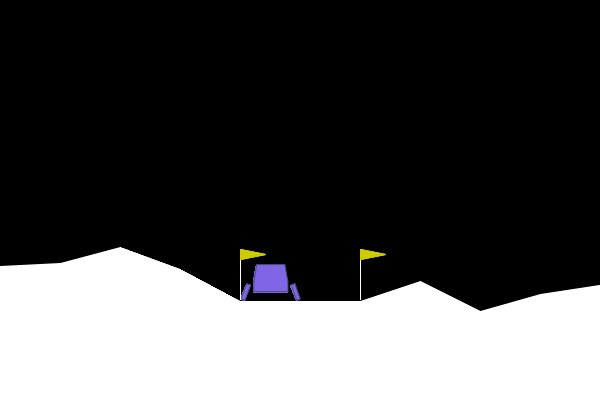

Final score: 296.06246995696023
Average score: 235.299670766659


In [9]:
env = gym.make('LunarLander-v3', render_mode="rgb_array")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# init agent
Q = QNetwork(state_size, action_size, hidden_size=128).to(device)

agent = Agent(
    state_size=state_size,
    action_size=action_size,
    Q_network=Q,
    gamma=0.995,
)

# load the weights from file
agent.Q.load_state_dict(torch.load('checkpoint.pth'))

env = gym.make("LunarLander-v3", render_mode="rgb_array")

avg_score = 0
for i in range(3):
	state, info = env.reset()
	total_reward = 0
	for t in range(500):
		# clear frame
		display.clear_output(wait=True)

		action = agent.select_action(state)

		# render game
		frame = env.render()
		display.display(Image.fromarray(frame))
		time.sleep(0.05)

		state, reward, done, _, info = env.step(action)
		total_reward += reward
		if done:
			break
	
	avg_score += total_reward
	print('Final score:', total_reward)
env.close()
print(f"Average score: {avg_score / 3}")

### 8. Summary


This implementation leverages an asynchronous parallel version of Deep Q-Learning, which eliminates the dependency on a replay buffer by using multiple processes to independently interact with the environment and update the shared Q-network. Compared to a traditional [Dueling DDQN](./dueling_ddqn_lunarlander.ipynb) implementation, which takes approximately **22 minutes** to solve the same task, this parallel version achieves a significant speedup. Running entirely on the **CPU**, it completes training in just **4.29 minutes**, demonstrating a **5x improvement in efficiency** while maintaining competitive performance. This acceleration is particularly beneficial for environments with computational constraints or limited access to GPUs.